## Model

In [19]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=757.00, M2=2111.00


In [20]:
set = gp.Model("set")
set.setParam("MIPGap", 1e-7)

x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")

yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

p1 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p1")
p2 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p2")
p3 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p3")
p4 = set.addVars(I, T, S, vtype=GRB.BINARY, name="p4")

set.update()

obj = gp.quicksum(P_DA[t] * gp.quicksum(x[i, t] for i in range(I)) for t in range(T)) + gp.quicksum((1 / S) * (P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in range(I)) - P_PN[t] * gp.quicksum(em[i, t, s] for i in range(I))) for t in range(T) for s in range(S))

set.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(yp[i, t, s] <= R[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
    set.addConstr(z[i, t, s] <= K[i])
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in range(I)))
    set.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in range(I)))
    set.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= M2 * p4[i, t, s])
    set.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) <= M2 * (1 - p4[i, t, s]))
    set.addConstr(d[i, i, t, s] == 0)

set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")
    
x_vals = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
d_vals = np.array([[[[d[i, j, t, s].x for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 40900 rows, 38620 columns and 129700 nonzeros
Model fingerprint: 0xa8c661ba
Variable types: 29020 continuous, 9600 integer (9600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 21658 rows and 17000 columns
Presolve time: 0.16s
Presolved: 19242 rows, 21620 columns, 61367 nonzeros
Variable types: 16483 continuous, 5137 integer (5137 binary)
Found heuristic solution: objective 964325.94506
Found heuristic solution: objective 1062899.2673

Root relaxation: objective 1.630378e+06, 20092 iterations, 0.53 seconds (0.59 work units)

    Nodes    |    Current Node    |     Objective Bou

## Demand Curve

In [21]:
# # === 설정 ===
# target_i = 4  # RDC를 도출할 대상 DER
# t, s = 20, 2  # 시간/시나리오 인덱스
# granularity = 1.0  # 계단당 MWh 수 (예: 1.0 → 1MWh 단위로 계단화)

# # Step 1: total internal demand excluding target_i
# total_demand = sum(ym_vals[i, t, s] for i in range(I) if i != target_i)

# # Step 2: internal profit
# given = 0
# received = 0
# for i in range(I):
#     for j in range(I):
#         if i == j:
#             continue
#         given += d_vals[i, j, t, s] * P_PN[t]
#         received += d_vals[j, i, t, s] * P_RT[t, s]
# internal_profit = given - received

# # Step 3: sort by y_minus descending
# demand_info = [(ym_vals[i, t, s], i) for i in range(I) if i != target_i]
# demand_info.sort(reverse=True)

# # Step 4: 세분화된 계단형 수요곡선 구성
# quantities = [0]
# prices = []

# cum_demand = 0
# for y_val, i in demand_info:
#     num_steps = int(np.ceil(y_val / granularity))
#     for step in range(num_steps):
#         step_size = min(granularity, y_val - step * granularity)
#         cum_demand += step_size
#         quantities.append(cum_demand)
#         price = internal_profit / cum_demand if cum_demand > 0 else 0
#         prices.append(price)

# # 마지막 계단 유지
# prices.append(prices[-1])

# # 수요곡선 DataFrame
# demand_df = pd.DataFrame({
#     "Quantity (d)": quantities,
#     "Price (ρ)": prices
# })

# # 출력
# print(f"[계단형 수요곡선 @ t={t}, s={s}] - Target DER: {target_i}")
# for i in range(I):
#     if i == target_i:
#         continue
#     print(f"DER {i}: y⁻ = {ym_vals[i, t, s]:.2f} MWh")

# # print(demand_df)

# # 시각화
# plt.figure(figsize=(8, 5))
# plt.step(quantities, prices, where="post", label=f"Demand curve (internal, except DER {target_i})", color="blue")
# plt.title(f"Step Demand Curve @ t={t}, s={s} (Excl. DER {target_i})")
# plt.xlabel("Cumulative Demand (MWh)")
# plt.ylabel("Internal Price")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [22]:
# # === 설정 ===
# target_i = 4  # 제외할 DER
# t, s = 20, 2  # 시간, 시나리오 인덱스

# # Step 1: 각 DER의 수요 정보 수집 및 정렬 (descending y⁻)
# demand_info = [(ym_vals[i, t, s], i) for i in range(I) if i != target_i]
# demand_info.sort(reverse=True)  # 수요량 많은 순

# # Step 2: Internal Profit 계산
# given = 0
# received = 0
# for i in range(I):
#     for j in range(I):
#         if i == j:
#             continue
#         given += d_vals[i, j, t, s] * P_PN[t]
#         received += d_vals[j, i, t, s] * P_RT[t, s]
# internal_profit = given - received

# total_demand = sum(y for y, _ in demand_info)

# # Step 3: 수요자 수 및 가격 범위 설정
# N = len(demand_info)
# rho_max = P_PN[t]
# rho_min = internal_profit / total_demand if total_demand > 0 else 0 
# # rho_min = P_RT[t, s]
# step_prices = np.linspace(rho_max, rho_min, N)

# # Step 4: 계단형 수요곡선 구성
# quantities = [0]
# prices = []

# cum_demand = 0
# for (y_val, i), price in zip(demand_info, step_prices):
#     cum_demand += y_val
#     quantities.append(cum_demand)
#     prices.append(price)

# # 마지막 가격 유지
# prices.append(prices[-1])

# # DataFrame 구성
# demand_df = pd.DataFrame({
#     "Quantity (d)": quantities,
#     "Price (ρ)": prices
# })

# # === 출력 및 시각화 ===
# print(f"[현실기반 수요곡선 생성 @ t={t}, s={s}] - Target DER: {target_i}")
# print(f"- Internal profit: {internal_profit:.2f}")
# print(f"- Total demand (excluding target): {total_demand:.2f} MWh")
# for y_val, i in demand_info:
#     print(f"  DER {i}: y⁻ = {y_val:.2f} MWh")

# print(demand_df)

# plt.figure(figsize=(8, 5))
# plt.step(quantities, prices, where="post", label=f"Demand curve (internal, except DER {target_i})", color="blue")
# plt.title(f"WTP-based Step Demand Curve @ t={t}, s={s} (Excl. DER {target_i})")
# plt.xlabel("Cumulative Demand (MWh)")
# plt.ylabel("Internal Price")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [23]:
# # === 설정 ===
# target_i = 4  # 제외할 DER
# t, s = 20, 2  # 시간, 시나리오 인덱스

# # Step 1: Internal Profit & 총 수요량 계산
# total_demand = sum(ym_vals[i, t, s] for i in range(I) if i != target_i)

# given = 0
# received = 0
# for i in range(I):
#     for j in range(I):
#         if i == j:
#             continue
#         given += d_vals[i, j, t, s] * P_PN[t]
#         received += d_vals[j, i, t, s] * P_RT[t, s]
# internal_profit = given - received

# # Step 2: 수요곡선 계단 설정
# N = 20  # 원하는 계단 개수
# x_min = 0
# x_max = 1.1 * total_demand
# step_quantity = (x_max - x_min) / N

# # 가격 설정
# rho_max = P_PN[t]
# rho_min = internal_profit / total_demand if total_demand > 0 else 0
# # rho_min = P_RT[t, s]
# step_prices = np.linspace(rho_max, rho_min, N)

# # 계단형 수요곡선 생성
# quantities = [x_min + i * step_quantity for i in range(N + 1)]
# prices = [step_prices[i] for i in range(N) for _ in range(2)]
# quantities_step = [quantities[i] for i in range(N) for _ in range(2)]
# quantities_step.append(quantities[-1])
# prices.append(prices[-1])

# # DataFrame
# demand_df = pd.DataFrame({
#     "Quantity (d)": quantities_step,
#     "Price (ρ)": prices
# })

# # === 출력 및 시각화 ===
# print(f"[균등분할 우하향 수요곡선 @ t={t}, s={s}] - Target DER: {target_i}")
# print(f"- Internal profit: {internal_profit:.2f}")
# print(f"- Total demand: {total_demand:.2f} MWh")
# # print(demand_df)

# plt.figure(figsize=(8, 5))
# plt.step(demand_df["Quantity (d)"], demand_df["Price (ρ)"], where="post",
#          label=f"Step Demand Curve (Excl. DER {target_i})", color="blue")
# plt.title(f"Uniform Step Demand Curve @ t={t}, s={s}")
# plt.xlabel("Cumulative Demand (MWh)")
# plt.ylabel("Internal Price")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [24]:
# # === 설정 ===
# target_i = 4  # 제외할 DER
# t, s = 20, 2  # 시간, 시나리오 인덱스

# # Step 1: Internal Profit & 총 수요량 계산
# total_demand = sum(ym_vals[i, t, s] for i in range(I) if i != target_i)

# given_d = 0
# received_d = 0
# for i in range(I):
#     for j in range(I):
#         if i == j:
#             continue
#         given_d += d_vals[i, j, t, s] * P_PN[t]
#         received_d += d_vals[j, i, t, s] * P_RT[t, s]
# internal_profit_d = given_d - received_d

# # Step 2: 선형 수요곡선 파라미터 계산
# rho_max = P_PN[t]  # 최대 WTP: 페널티 피하려는 가격
# rho_min = received_d / total_demand if total_demand > 0 else 0  # 평균 내부 정산 단가
# # rho_min = (given - received) / total_demand if total_demand > 0 else 0  # 평균 내부 정산 단가

# # 선형 함수식: ρ(d) = a - b*d 형태
# a = rho_max
# b = (rho_max - rho_min) / total_demand if total_demand > 0 else 0

# # 수요함수 정의
# def rho_d(d):
#     return a - b * d

# # 시각화를 위한 수요곡선 생성
# quantities = np.linspace(0, 1.1 * total_demand, 300)
# prices = rho_d(quantities)

# # DataFrame
# demand_df = pd.DataFrame({
#     "Quantity (d)": quantities,
#     "Price (ρ)": prices
# })

# # 출력
# print(f"[선형 수요곡선 @ t={t}, s={s}] - Target DER: {target_i}")
# print(f"- Received : {received_d:.2f}")
# print(f"- Total demand: {total_demand:.2f} MWh")
# print(f"- Demand function: ρ(d) = {a:.2f} - {b:.2f} * d")

# # 시각화
# plt.figure(figsize=(8, 5))
# plt.plot(demand_df["Quantity (d)"], demand_df["Price (ρ)"],
#          label=f"Linear Demand Curve (Excl. DER {target_i})", color="blue")
# plt.title(f"Linear Demand Curve @ t={t}, s={s}")
# plt.xlabel("Cumulative Demand (MWh)")
# plt.ylabel("Internal Price (₩)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

[면적기반 선형 수요곡선 @ t=20, s=2] - Target DER: 4
- 총 수요량 (ym 기준): 26.00 MWh
- 총 지급액 (received): 2449.66 ₩
- 수요함수: ρ(d) = 189.50 - 7.33 * d


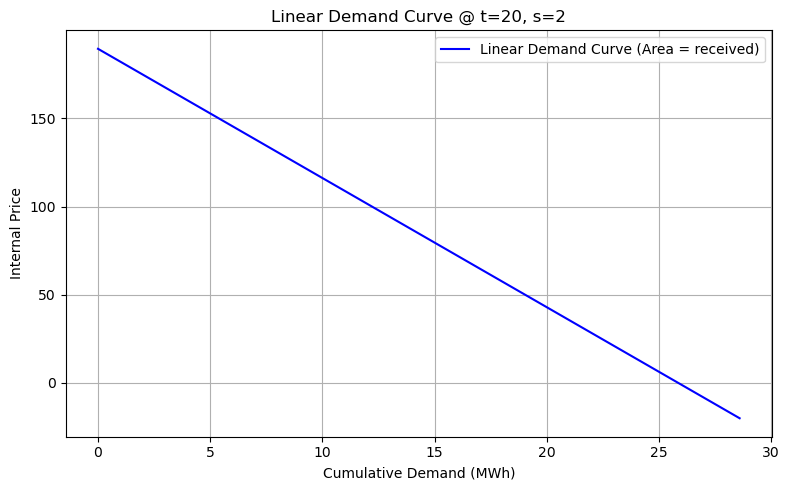

In [25]:
# === 설정 ===
target_i = 4  # 제외할 DER
t, s = 20, 2  # 시간/시나리오 인덱스

# Step 1: 총 수요량 (ym 기준)
total_demand = sum(ym_vals[i, t, s] for i in range(I) if i != target_i)

# Step 2: 내부 정산 지급 총액 (received, d 기반)
received_d = 0
for i in range(I):
    for j in range(I):
        if i == j:
            continue
        received_d += d_vals[j, i, t, s] * P_RT[t, s]

# Step 3: 선형 함수 계수 도출 (면적 = received 조건)
# 선형 수요곡선: ρ(d) = a - b*d → 면적 = a*Q - 0.5*b*Q^2 = received
# b = slope, a = intercept (보통 a = P_PN[t])
Q = total_demand
area = received_d
a = P_PN[t]
b = 2 * (a * Q - area) / (Q ** 2) if Q > 0 else 0

# 수요곡선 함수
def rho_d(d):
    return a - b * d

# === Step 4: 곡선 시각화
quantities = np.linspace(0, 1.1 * Q, 300)
prices = rho_d(quantities)

demand_df = pd.DataFrame({
    "Quantity (d)": quantities,
    "Price (ρ)": prices
})

# === 출력 ===
print(f"[면적기반 선형 수요곡선 @ t={t}, s={s}] - Target DER: {target_i}")
print(f"- 총 수요량 (ym 기준): {Q:.2f} MWh")
print(f"- 총 지급액 (received): {received_d:.2f} ₩")
print(f"- 수요함수: ρ(d) = {a:.2f} - {b:.2f} * d")

# === 시각화 ===
plt.figure(figsize=(8, 5))
plt.plot(demand_df["Quantity (d)"], demand_df["Price (ρ)"],
         label=f"Linear Demand Curve (Area = received)", color="blue")
plt.title(f"Linear Demand Curve @ t={t}, s={s}")
plt.xlabel("Cumulative Demand (MWh)")
plt.ylabel("Internal Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Supply Curve w/o i*

#### Optimization w/o i*

In [26]:
# === 설정 ===
target_i = 4  # RDC를 도출할 대상 DER

I_set = [i for i in range(I) if i != target_i]
M1 = np.maximum(R[I_set], K[I_set, None, None]).max()
M2 = max(R[I_set].sum(axis=0).max(), K[I_set].sum())

model = gp.Model(f"set_without_{target_i}")
model.setParam("MIPGap", 1e-7)

# 변수 정의
x = model.addVars(I_set, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
ep = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
yp = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = model.addVars(I_set, T + 1, S, vtype=GRB.CONTINUOUS, name="z")
zc = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = model.addVars(I_set, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
d = model.addVars(I_set, I_set, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")

p1 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p1")
p2 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p2")
p3 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p3")
p4 = model.addVars(I_set, T, S, vtype=GRB.BINARY, name="p4")

model.update()

# 목적함수
obj = gp.quicksum(P_DA[t] * x[i, t] for i in I_set for t in range(T)) + gp.quicksum(
    (1 / S) * (
        P_RT[t, s] * gp.quicksum(ep[i, t, s] for i in I_set) -
        P_PN[t] * gp.quicksum(em[i, t, s] for i in I_set)
    )
    for t in range(T) for s in range(S)
)
model.setObjective(obj, GRB.MAXIMIZE)

# 제약조건
for i, t, s in product(I_set, range(T), range(S)):
    model.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    model.addConstr(yp[i, t, s] <= R[i, t, s])
    model.addConstr(zd[i, t, s] <= z[i, t, s])
    model.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    model.addConstr(yp[i, t, s] <= M1 * p3[i, t, s])
    model.addConstr(ym[i, t, s] <= M1 * (1 - p3[i, t, s]))
    model.addConstr(ym[i, t, s] <= M1 * p2[i, t, s])
    model.addConstr(zc[i, t, s] <= M1 * (1 - p2[i, t, s]))
    model.addConstr(zc[i, t, s] <= M1 * p1[i, t, s])
    model.addConstr(zd[i, t, s] <= M1 * (1 - p1[i, t, s]))
    model.addConstr(z[i, t, s] <= K[i])
    model.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])

for i, s in product(I_set, range(S)):
    model.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(I_set, range(T), range(S)):
    model.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(d[i, j, t, s] for j in I_set if j != i))
    model.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(d[j, i, t, s] for j in I_set if j != i))
    model.addConstr(gp.quicksum(ep[i, t, s] for i in I_set) <= M2 * p4[i, t, s])
    model.addConstr(gp.quicksum(em[i, t, s] for i in I_set) <= M2 * (1 - p4[i, t, s]))
    model.addConstr(d[i, i, t, s] == 0)

# 최적화
model.optimize()

x_vals = np.array([[x[i, t].X for t in range(T)] for i in I_set])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in I_set])
d_vals = np.array([[[[d[i, j, t, s].X for s in range(S)] for t in range(T)] for j in I_set] for i in I_set])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 32720 rows, 28976 columns and 92240 nonzeros
Model fingerprint: 0xd8e3eb80
Variable types: 21296 continuous, 7680 integer (7680 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 17167 rows and 12730 columns
Presolve time: 0.13s
Presolved: 15553 rows, 16246 columns, 47042 nonzeros
Variable types: 12061 continuous, 4185 integer (4185 binary)
Found heuristic solution: objective 867065.62420
Found heuristic solution: objective 1000809.3664

Root relaxation: objective 1.458720e+06, 16527 iterations, 0.39 seconds (0.42 work units)

    Nodes    |    Current Node    |     Objective Boun

#### Supply Curve

In [27]:
# # === 설정 ===
# t, s = 20, 2   # 시간/시나리오 인덱스
# i_map = {i: idx for idx, i in enumerate(I_set)}  # 실제 index → 내부 index 매핑

# # === Step 1: 공급자 i의 총 공급량 d_ij 계산 ===
# supply_list = []

# for i in I_set:
#     i_idx = i_map[i]
#     supplied = sum(
#         d_vals[i_idx, i_map[j], t, s]
#         for j in I_set if j != i
#     )
#     supply_list.append((supplied, i))

# supply_list.sort()

# # === Step 2: 계단형 공급곡선 구성 ===
# quantities = [0]
# prices = []

# total_supply = sum(q for q, _ in supply_list)
# N = len(supply_list)

# rho_min = 0.5 * (P_PN[t] - P_RT[t, s])
# rho_max = 1.5 * (P_PN[t] - P_RT[t, s])

# price_steps = np.linspace(rho_min, rho_max, N)

# for (q, i), rho in zip(supply_list, price_steps):
#     quantities.append(quantities[-1] + q)
#     prices.append(rho)

# prices.append(prices[-1])  # 마지막 가격 유지

# # === Step 3: 시각화 ===
# supply_df = pd.DataFrame({
#     "Cumulative Supply (d)": quantities,
#     "Price (ρ)": prices
# })

# print(f"\n[공급기여자 분석 @ t={t}, s={s}]")
# for q, i in supply_list:
#     if q > 1e-4:
#         print(f" - DER {i} supplied: {q:.3f} MWh")
        
# print(f"\n[공급곡선 @ t={t}, s={s}] - Target DER: {target_i}")
# print(supply_df)

# plt.step(quantities, prices, where="post", label=f"Supply curve (except DER {target_i})", color = 'red')
# plt.xlabel("Cumulative Supply (MWh)")
# plt.ylabel("Internal Price (ρ)")
# plt.title(f"Supply Curve (excluding DER {target_i})")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [28]:
# # === 설정 ===
# t, s = 20, 2
# target_i = 4  # 제외된 DER
# I_set = [i for i in range(I) if i != target_i]
# i_map = {i: idx for idx, i in enumerate(I_set)}

# # === Step 1: 전체 공급량 계산 ===
# supply_list = []
# for i in I_set:
#     i_idx = i_map[i]
#     supplied = sum(
#         d_vals[i_idx, i_map[j], t, s]
#         for j in I_set if j != i
#     )
#     supply_list.append(supplied)

# total_supply = sum(supply_list)

# # === Step 2: 균등 계단 설정 ===
# N = 20  # 계단 개수
# x_min = 0
# x_max = 1.1 * total_supply
# step_quantity = (x_max - x_min) / N

# # 가격 범위
# rho_min = 0.5 * (P_PN[t] - P_RT[t, s])
# rho_max = 1.5 * (P_PN[t] - P_RT[t, s])
# step_prices = np.linspace(rho_min, rho_max, N)

# # === Step 3: 계단형 공급곡선 구성 ===
# quantities = [x_min + i * step_quantity for i in range(N + 1)]
# prices = [step_prices[i] for i in range(N) for _ in range(2)]
# quantities_step = [quantities[i] for i in range(N) for _ in range(2)]
# quantities_step.append(quantities[-1])
# prices.append(prices[-1])

# # === Step 4: DataFrame 및 시각화 ===
# supply_df = pd.DataFrame({
#     "Cumulative Supply (d)": quantities_step,
#     "Price (ρ)": prices
# })

# print(f"\n[균등단계 공급곡선 @ t={t}, s={s}] - Target DER: {target_i}")
# print(f"- Total Supply: {total_supply:.2f} MWh")
# # print(supply_df)

# plt.figure(figsize=(8, 5))
# plt.step(supply_df["Cumulative Supply (d)"], supply_df["Price (ρ)"], where="post",
#          label=f"Uniform Step Supply Curve (Excl. DER {target_i})", color='red')
# plt.title(f"Uniform Step Supply Curve @ t={t}, s={s}")
# plt.xlabel("Cumulative Supply (MWh)")
# plt.ylabel("Internal Price (₩)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [29]:
# # === 설정 ===
# t, s = 20, 2
# target_i = 4
# I_set = [i for i in range(I) if i != target_i]
# i_map = {i: idx for idx, i in enumerate(I_set)}

# # === Step 1: 공급 총량 및 수익 계산 ===
# total_supply = sum(yp_vals[i_map[i], t, s] for i in I_set)

# # 내부 정산 수익 (given) 계산
# given = 0
# for i in I_set:
#     for j in I_set:
#         if i == j:
#             continue
#         given += d_vals[i_map[i], i_map[j], t, s] * P_PN[t]

# # === Step 2: 가격 범위 및 선형 공급곡선 계수 설정 ===
# # rho_min = 0.5 * given / total_supply if total_supply > 0 else 0  # 평균 정산 단가
# # rho_max = 1.5 * rho_min
# # a = rho_min
# # b = (rho_max - rho_min) / total_supply if total_supply > 0 else 0

# # Step 3: 기울기 고정 (economic interpretation)
# b = P_PN[t] - P_RT[t, s]
# Q = total_supply

# # Step 4: 절편 계산
# a = (given - 0.5 * b * Q**2) / Q if Q > 0 else 0

# # 공급 함수 정의
# def rho_d(d):
#     return a + b * d

# # === Step 3: 공급곡선 시각화용 데이터 생성 ===
# quantities = np.linspace(0, 1.1 * total_supply, 300)
# prices = rho_d(quantities)

# supply_df = pd.DataFrame({
#     "Cumulative Supply (d)": quantities,
#     "Price (ρ)": prices
# })

# # === 출력 및 시각화 ===
# print(f"[선형 공급곡선 @ t={t}, s={s}] - Target DER: {target_i}")
# print(f"- Total Realized Supply (y⁺): {total_supply:.2f} MWh")
# print(f"- Internal Revenue (given): {given:.2f}")
# print(f"- Supply function: ρ(d) = {a:.2f} + {b:.2f} * d")

# plt.figure(figsize=(8, 5))
# plt.plot(supply_df["Cumulative Supply (d)"], supply_df["Price (ρ)"],
#          label=f"Linear Supply Curve (Excl. DER {target_i})", color='red')
# plt.title(f"Linear Supply Curve @ t={t}, s={s}")
# plt.xlabel("Cumulative Supply (MWh)")
# plt.ylabel("Internal Price")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

- Total y⁺: 12.00 MWh
- Total given: 2274.01
- Supply function: ρ(d) = 94.22 + 15.88 * d


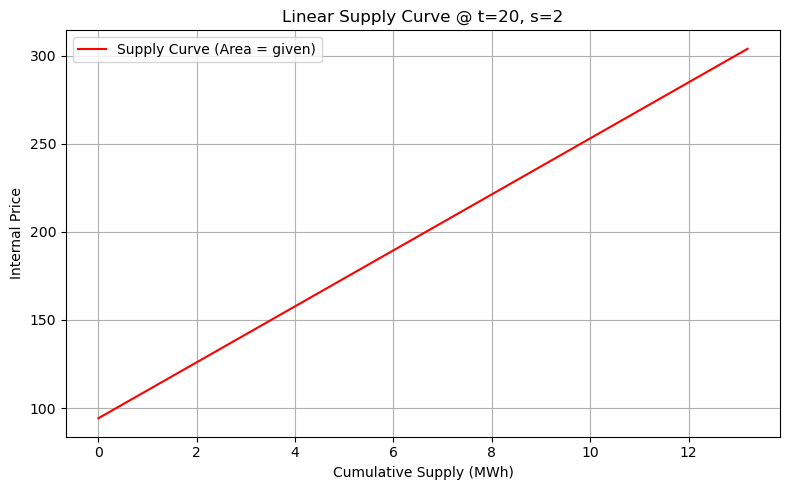

In [30]:
# === 설정 ===
t, s = 20, 2
target_i = 4
I_set = [i for i in range(I) if i != target_i]
i_map = {i: idx for idx, i in enumerate(I_set)}

# === Step 1: 공급 총량 및 수익 계산 ===
total_supply = sum(yp_vals[i_map[i], t, s] for i in I_set)

# 내부 정산 수익 (given) 계산
given_s, received_s = 0, 0
for i in I_set:
    for j in I_set:
        if i == j:
            continue
        given_s += d_vals[i_map[i], i_map[j], t, s] * P_PN[t]
        received_s += d_vals[i_map[j], i_map[i], t, s] * P_RT[t, s]
internal_profit_s = given_s - received_s

Q = total_supply  # = sum of yp[i_map[i], t, s]
area = given_s      # = sum of d_ij * P_PN[t]

a = P_RT[t, s]     # 최소 수용 가격 (기회비용)
b = 2 * (area - a * Q) / (Q ** 2) if Q > 0 else 0

# 공급곡선
def rho_s(d):
    return a + b * d

quantities = np.linspace(0, 1.1 * Q, 300)
prices = rho_s(quantities)

# DataFrame
supply_df = pd.DataFrame({
    "Quantity (d)": quantities,
    "Price (ρ)": prices
})

# 시각화

print(f"- Total y⁺: {Q:.2f} MWh")
print(f"- Total given: {given_s:.2f}")
print(f"- Supply function: ρ(d) = {a:.2f} + {b:.2f} * d")

plt.figure(figsize=(8, 5))
plt.plot(quantities, prices, label="Supply Curve (Area = given)", color="red")
plt.title(f"Linear Supply Curve @ t={t}, s={s}")
plt.xlabel("Cumulative Supply (MWh)")
plt.ylabel("Internal Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Supply-Demand Curve

In [31]:
# # 수요곡선: ρ(d) = a_d - b_d * d
# a_d = P_PN[t]
# b_d = 2 * (a_d * total_demand - received) / (total_demand ** 2)

# # 공급곡선: ρ(d) = a_s + b_s * d
# a_s = P_RT[t, s]
# b_s = 2 * (given - a_s * total_supply) / (total_supply ** 2)

In [32]:
# 수요곡선: ρ(d) = a_d - b_d * d
a_d = P_PN[t]
b_d = 2 * (a_d * total_demand - received_d) / (total_demand ** 2)

# 공급곡선: ρ(d) = a_s + b_s * d
a_s = P_RT[t, s]
b_s = 2 * (given_s - a_s * total_supply) / (total_supply ** 2)

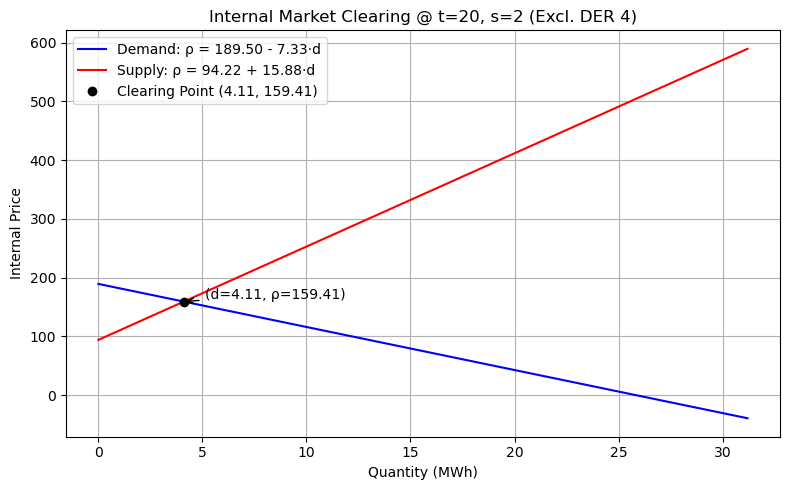

In [33]:
# === 교차점 계산 ===
q_clearing = (a_d - a_s) / (b_d + b_s) if (b_d + b_s) != 0 else 0
p_clearing = a_s + b_s * q_clearing  # 또는 a_d - b_d * q_clearing

# === 시각화 ===
x_max = 1.2 * max(total_demand, total_supply, q_clearing)
quantities = np.linspace(0, x_max, 300)
demand_prices = a_d - b_d * quantities
supply_prices = a_s + b_s * quantities

plt.figure(figsize=(8, 5))
plt.plot(quantities, demand_prices, label=f"Demand: ρ = {a_d:.2f} - {b_d:.2f}·d", color='blue')
plt.plot(quantities, supply_prices, label=f"Supply: ρ = {a_s:.2f} + {b_s:.2f}·d", color='red')
plt.plot(q_clearing, p_clearing, 'ko', label=f"Clearing Point ({q_clearing:.2f}, {p_clearing:.2f})")
plt.annotate(f"(d={q_clearing:.2f}, ρ={p_clearing:.2f})", 
             xy=(q_clearing, p_clearing), 
             xytext=(q_clearing + 1, p_clearing + 5),
             arrowprops=dict(arrowstyle="->"))

plt.title(f"Internal Market Clearing @ t={t}, s={s} (Excl. DER {target_i})")
plt.xlabel("Quantity (MWh)")
plt.ylabel("Internal Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()